In [2]:
import pandas as pd
import openpyxl
import numpy as np
import os
import glob2
import glob
import random
import sklearn
import ntpath
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from nltk.test.portuguese_en_fixt import setup_module
import nltk
from contextlib import nullcontext
import unicodedata
import plotly
import read_file_exec as rfe

In [3]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(42)

## Puxada dos dados modelados do processo de extração

In [4]:
modelo_inventario = rfe.read_file('etl_results/tempo_em_estoque.xlsx').get_df()
modelo_transac_prod = rfe.read_file('etl_results/transacoes_produto_tratado_final.xlsx').get_df()

## Dados de Inventário

In [5]:
modelo_inventario.head(30)


,codigo,descricao,categoria,estoque_disponivel,preco,incluido_em,alterado_em,ncm,taxa_depreciacao,ano_mes,mes,indice,te_inicio_presente,te_atualizacao_presente,te_inicio_atualizacao,anos_estoque,clf_estoque,fator_atualizacao,depreciacao_unit,fator_correcao,correcao_unit,correcao_deprec,depreciacao,valor_ini,valor_estoque_deprec,valor_estoque_depreciado_corrigido
0,7100692,APLIQUE - APM4 -053 NOIVOS,papelaria,9.0,2.5,2020-11-16 17:19:42.000,2021-04-13 15:15:27.708,3926,0,2021-04,2021-04-01,5692.31,620,472,147,1.292292,Produto no estoque,0.76129,0.0,1.126423,2.816058,2.816058,0.0,22.5,0.0,0.0
1,099939,MASSA BISCUIT acrilex 90G - AMARELO PELE,papelaria,0.0,4.5,2020-03-12 09:25:38.569,2021-04-13 14:54:44.957,3926,0,2021-04,2021-04-01,5692.31,870,472,397,1.292292,Produto não está em estoque,1.00000,0.0,1.126423,5.068904,5.068904,0.0,0.0,0.0,0.0
2,099935,MASSA BISCUIT acrilex 90G - VERDE MUSGO,papelaria,0.0,4.5,2020-03-12 09:11:30.999,2021-04-13 14:55:19.701,3926,0,2021-04,2021-04-01,5692.31,870,472,397,1.292292,Produto não está em estoque,1.00000,0.0,1.126423,5.068904,5.068904,0.0,0.0,0.0,0.0
3,099993,PINCEL TIGRE 815 - 04,papelaria,3.0,3.5,2020-03-12 16:23:51.521,2021-04-30 17:10:25.288,3926,0,2021-04,2021-04-01,5692.31,869,455,414,1.245748,Produto no estoque,0.52359,0.0,1.126423,3.942481,3.942481,0.0,10.5,0.0,0.0
4,099996,PINCEL TIGRE 815 - 10,papelaria,4.0,5.0,2020-03-12 16:28:07.014,2021-04-30 17:11:11.816,3926,0,2021-04,2021-04-01,5692.31,869,455,414,1.245748,Produto no estoque,0.52359,0.0,1.126423,5.632116,5.632116,0.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,7100369,ACRIPUFF - AMARELO OURO,papelaria,6.0,2.5,2020-10-27 15:05:06.788,2021-06-25 09:59:20.733,3926,0,2021-06,2021-06-01,5769.98,640,400,240,1.095163,Produto no estoque,0.62500,0.0,1.111260,2.778151,2.778151,0.0,15.0,0.0,0.0
26,7100372,ACRIPUFF - BRANCO,papelaria,2.0,2.5,2020-10-27 15:42:30.541,2021-06-25 09:59:33.484,3926,0,2021-06,2021-06-01,5769.98,640,400,240,1.095163,Produto no estoque,0.62500,0.0,1.111260,2.778151,2.778151,0.0,5.0,0.0,0.0
27,7100370,ACRIPUFF - PRETO,papelaria,4.0,2.5,2020-10-27 15:40:31.781,2021-06-25 09:59:57.732,3926,0,2021-06,2021-06-01,5769.98,640,400,240,1.095163,Produto no estoque,0.62500,0.0,1.111260,2.778151,2.778151,0.0,10.0,0.0,0.0
28,7100371,ACRIPUFF - VERMELHO,papelaria,2.0,2.5,2020-10-27 15:41:18.222,2021-06-25 10:00:10.741,3926,0,2021-06,2021-06-01,5769.98,640,400,240,1.095163,Produto no estoque,0.62500,0.0,1.111260,2.778151,2.778151,0.0,5.0,0.0,0.0


In [6]:
modelo_transac_prod.head(30)

,tipo,numero,data,hora,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,gerado_clf_auto,total,codigo,categoria
0,Ajuste de Custo,38041,2022-07-20 17:40:01.564,2022-07-20 17:40:01.564,LINHA CLÉA 125 -5899 PANTANAL,0.0,9.25,0.0,0.0,0,S,0.0,85922412,linha
1,Ajuste de Estoque +,38040,2022-07-20 17:40:01.374,2022-07-20 17:40:01.374,LINHA CLÉA 125 -5899 PANTANAL,10.0,0.00,0.0,0.0,0,S,0.0,15042603,linha
2,Ajuste de Custo,36992,2022-06-16 10:35:44.146,2022-06-16 10:35:44.146,"AGULHA CROCHE LULI - 5,5",0.0,3.00,0.0,0.0,0,S,0.0,3456886,armarinho
3,Ajuste de Estoque +,36991,2022-06-16 10:35:43.968,2022-06-16 10:35:43.968,"AGULHA CROCHE LULI - 5,5",12.0,0.00,0.0,0.0,0,S,0.0,99629223,armarinho
4,Venda,36767,2022-06-09 10:42:36.640,2022-06-09 10:42:36.640,PAPEL DECOUPAGE-AFQ-032,-1.0,3.00,3.0,0.0,0,S,3.0,37013810,papelaria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Ajuste de Estoque +,35917,2022-05-14 10:42:42.059,2022-05-14 10:42:42.059,GOLA TRICO MARROM,1.0,0.00,0.0,0.0,0,S,0.0,26787537,armarinho
26,Venda,35883,2022-05-12 17:40:54.992,2022-05-12 17:40:54.992,PAPEL DECOUPAGE - AD11,-1.0,3.00,3.0,0.2,0,S,2.8,96202525,papelaria
27,Ajuste de Custo,35802,2022-05-11 16:58:00.865,2022-05-11 16:58:00.865,ALÇA P BOLSA CORRENTE ACRILICO,0.0,16.00,0.0,0.0,0,S,0.0,87326012,armarinho
28,Ajuste de Estoque +,35801,2022-05-11 16:58:00.698,2022-05-11 16:58:00.698,ALÇA P BOLSA CORRENTE ACRILICO,1.0,0.00,0.0,0.0,0,S,0.0,94230244,armarinho


<Figure size 640x480 with 0 Axes>

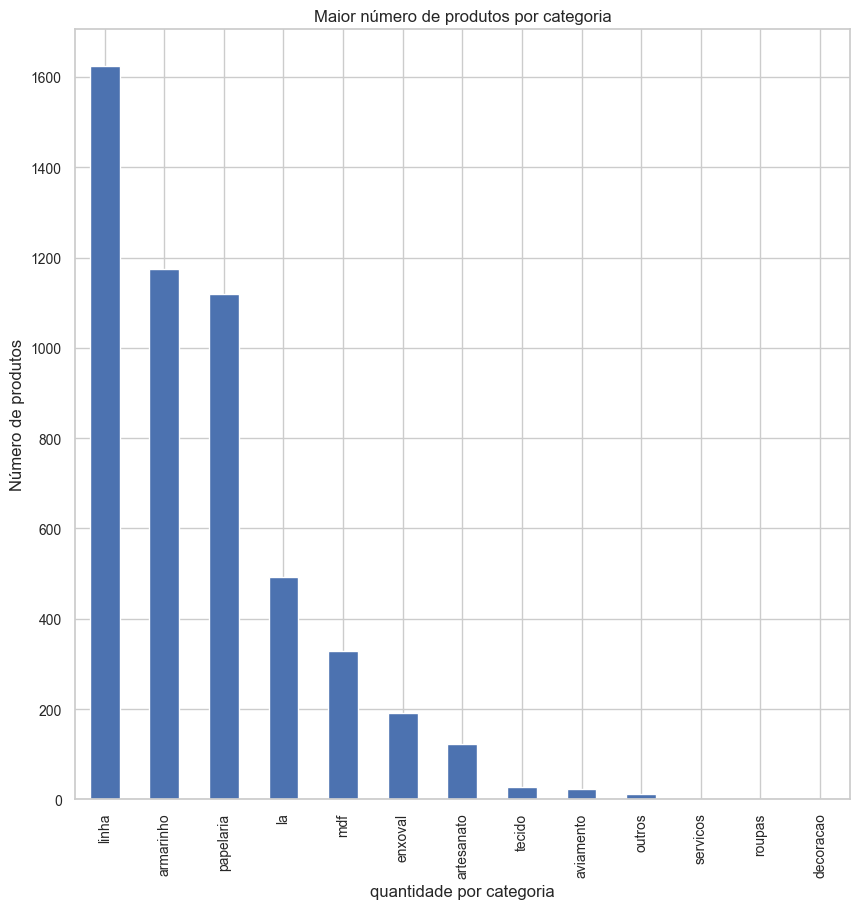

In [7]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)


plot_rank_categoria = modelo_inventario['categoria'].value_counts().plot(kind='bar', title='Maior número de produtos por categoria',figsize=(10,10))
plot_rank_categoria.set_xlabel('quantidade por categoria')
plot_rank_categoria.set_ylabel('Número de produtos')
plt.show()

In [8]:
classificacao_inv = modelo_inventario.groupby('clf_estoque').agg({'categoria': 'nunique', 'codigo': 'count'})
classificacao_inv.head()

,categoria,codigo
clf_estoque,,
Produto alterado no último trimestre,10,186
Produto no estoque,9,3130
Produto não está em estoque,12,927
Risco de estoque parado,10,878


<Figure size 640x480 with 0 Axes>

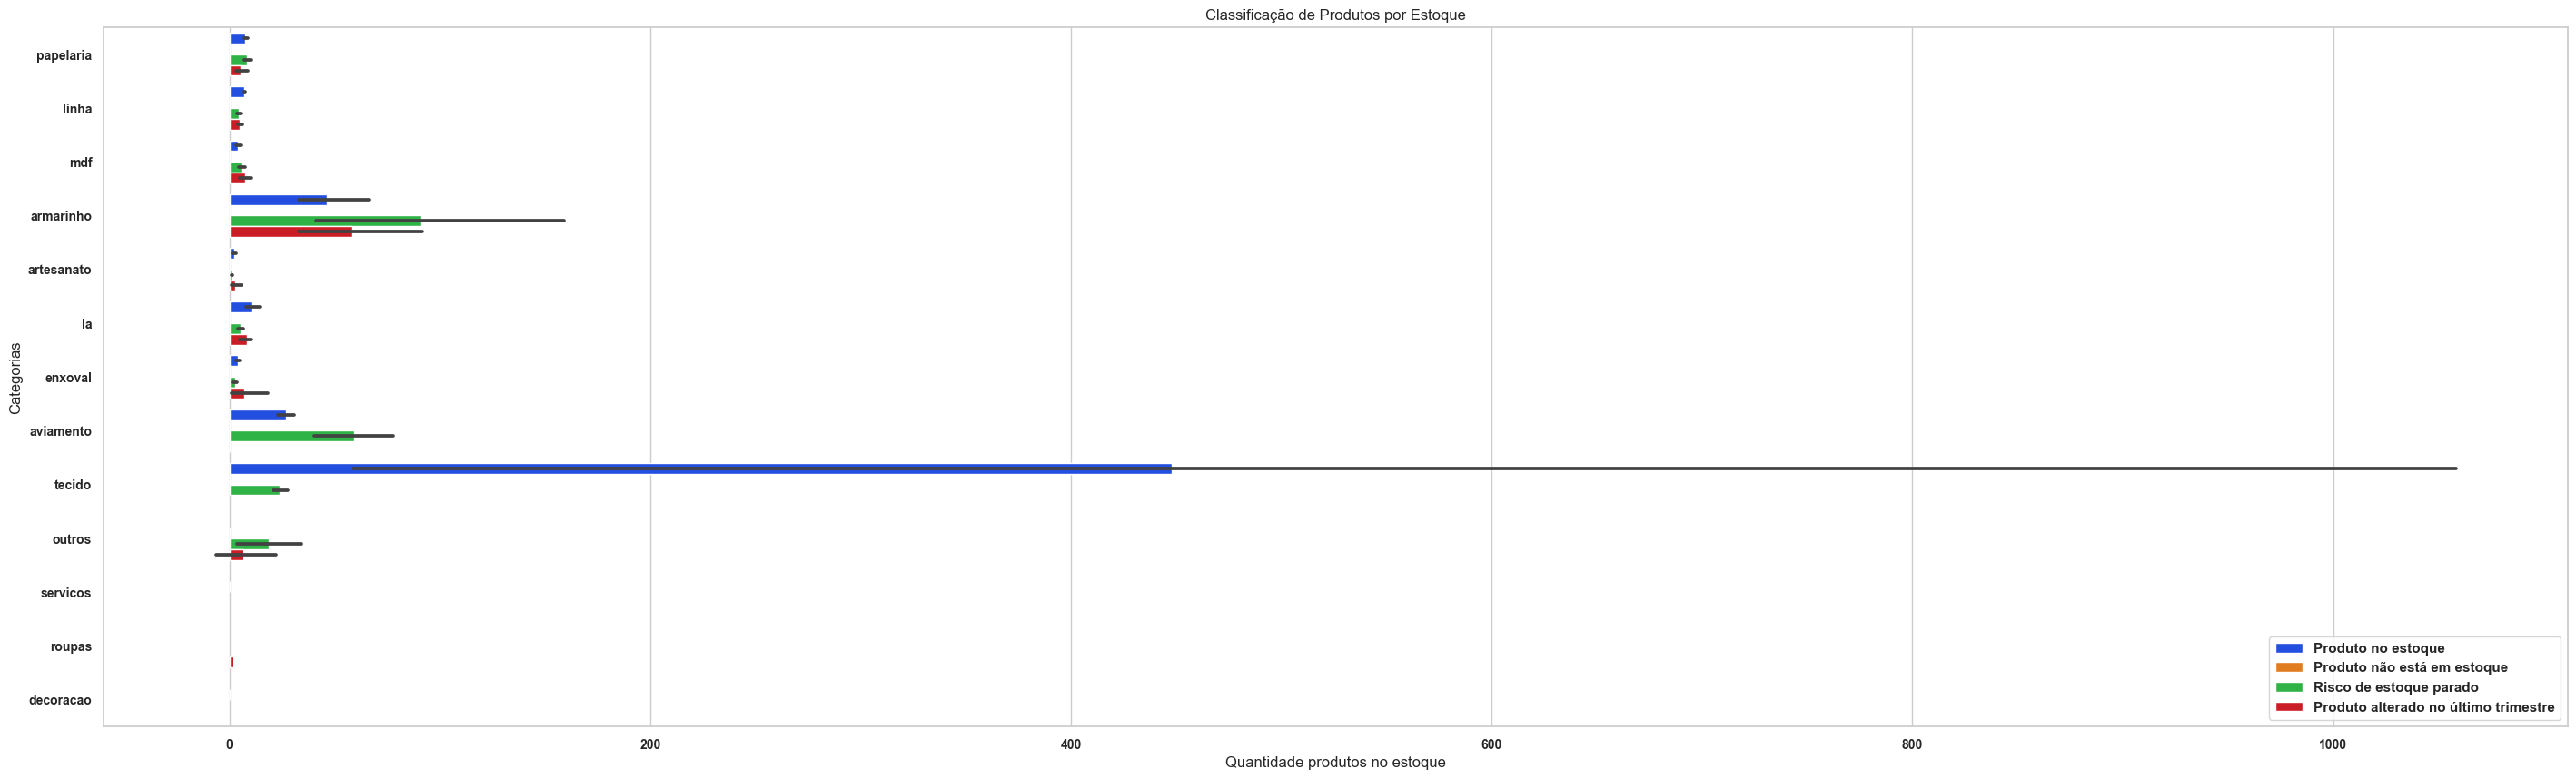

<Figure size 2000x2000 with 0 Axes>

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (35,10)
plt.rcParams.update({'font.size': 45, 'font.weight': 'bold', 'font.family': 'sans-serif', 'font.sans-serif': 'Arial'})
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

#plot by clf_estoque from tempo_em_estoque

plot_classificacao_inv = sns.barplot(x='estoque_disponivel', y='categoria', data=modelo_inventario, hue='clf_estoque', palette='bright', ax=ax)
plot_classificacao_inv.set_xlabel('Quantidade produtos no estoque')
plot_classificacao_inv.set_ylabel('Categorias')
plot_classificacao_inv.set_title('Classificação de Produtos por Estoque')
plot_classificacao_inv.legend(loc='lower right')
plt.figure(figsize=(20,20))
plt.show()

In [10]:
tempo_em_estoque_parado = modelo_inventario[modelo_inventario['clf_estoque'] == 'Risco de estoque parado']
agrupamento_clf = tempo_em_estoque_parado.groupby(['categoria']).agg({'codigo': 'count','preco': 'mean','estoque_disponivel': 'mean'})
agrupamento_clf

,codigo,preco,estoque_disponivel
categoria,,,
armarinho,170,8.248882,90.878353
artesanato,16,92.062500,1.250000
aviamento,18,5.138889,59.472222
enxoval,23,56.260870,2.652174
la,18,32.600000,5.388889
linha,47,38.385106,4.595745
mdf,126,16.509127,5.801587
outros,4,17.325000,18.625000
papelaria,452,5.823230,8.265487


Será considerado uma análise dos itens classificados como "Risco de estoque parado".

In [11]:
agrupamento_risco = modelo_inventario[modelo_inventario['clf_estoque'] == 'Risco de estoque parado'].groupby(['clf_estoque','categoria']).agg({'codigo': 'count','preco': 'mean','estoque_disponivel': 'mean','te_inicio_presente': 'mean','te_atualizacao_presente': 'mean','te_inicio_atualizacao': 'mean','fator_atualizacao': 'mean','depreciacao': 'mean'})
for index, row in agrupamento_risco.iterrows():
    agrupamento_risco = agrupamento_risco.drop(index)
    

<Figure size 40x30 with 0 Axes>

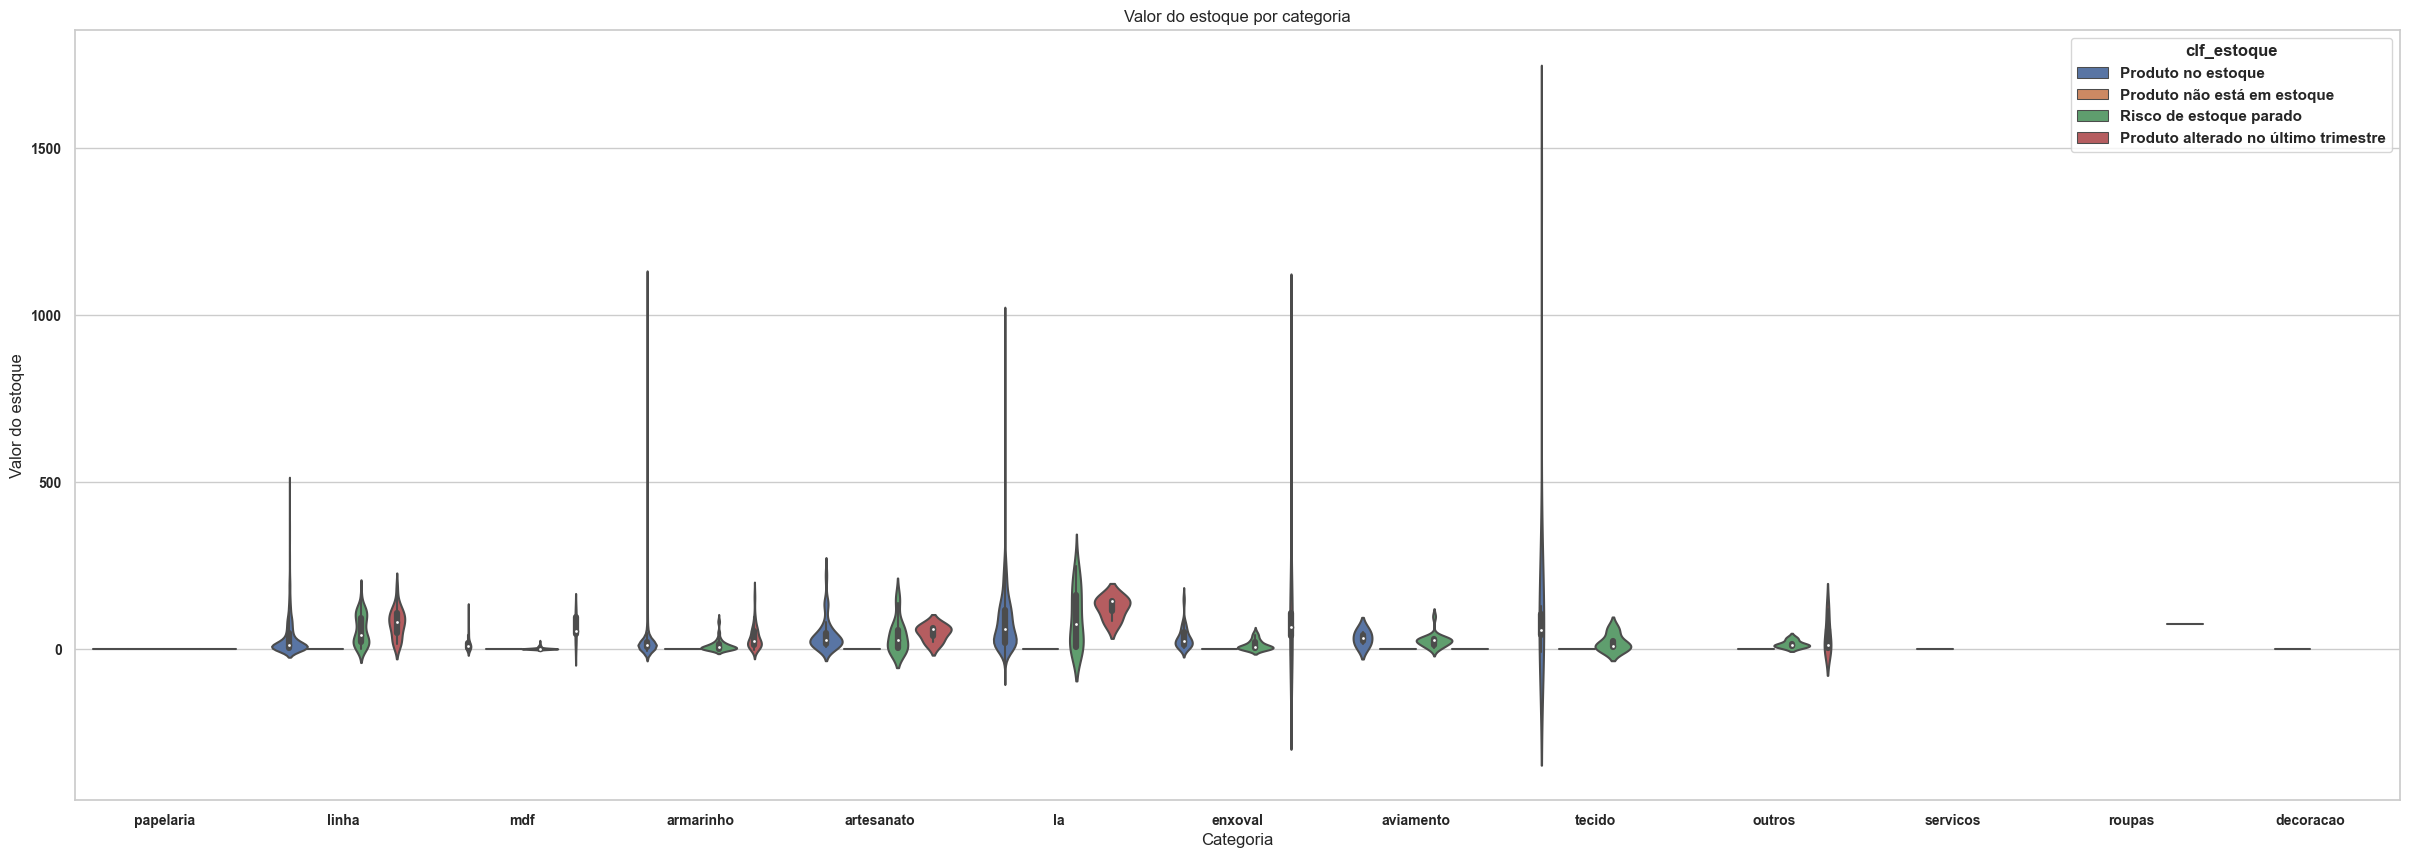

<Figure size 2000x2000 with 0 Axes>

In [12]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=5)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

b=sns.violinplot(x = 'categoria',y='valor_estoque_depreciado_corrigido', data=modelo_inventario, hue='clf_estoque')
b.set_xlabel('Categoria')
b.set_ylabel('Valor do estoque')
b.set_title('Valor do estoque por categoria')
plt.figure(figsize=(20,20))
plot_classificacao_inv.legend(loc='upper left')
plt.show()


In [13]:
#Rank de produtos em estoque por categoria com risco de estarem parados
top_10_fator_atualizacao_2 = modelo_inventario[modelo_inventario['fator_atualizacao'] == 1]
top_10_fator_atualizacao_2 = top_10_fator_atualizacao_2.sort_values(by=['fator_atualizacao'], ascending=False).groupby('clf_estoque')

top_10_fator_atualizacao_2[['categoria','descricao','estoque_disponivel','te_inicio_atualizacao','fator_atualizacao']].head(50)


,categoria,descricao,estoque_disponivel,te_inicio_atualizacao,fator_atualizacao
1,papelaria,MASSA BISCUIT acrilex 90G - AMARELO PELE,0.0,397,1.0
2958,linha,BARBANTE TRENTO - CINZA 270,0.0,795,1.0
2754,armarinho,"AGULHA CROCHÊ CIRCULO - 3,5",0.0,710,1.0
2753,armarinho,AGULHA CROCHÊ CIRCULO - 3,0.0,710,1.0
2745,armarinho,"AGULHA CROCHÊ MILWARD 5,5mm",0.0,0,1.0
...,...,...,...,...,...
1746,armarinho,RENDA GUIPEARE CHL 589 VERMELHO,13.7,0,1.0
1745,armarinho,RENDA GUIPEARE CHL 589 ROSA 5CM,17.0,0,1.0
1744,armarinho,RENDA GUIPEARE CHL 589 PRETA,27.4,0,1.0
1743,armarinho,RENDA GUIPEARE CHL - 438 PRETA,13.7,0,1.0


## Conclusões após análise exploratória dos dados de inventário
Embora haja a análise de dados de inventário, durante entrevistas com o local estudado, foi descoberto de que há defasagem de dados de inventário, possuindo mais estoque do que o que está informado. Há casos em que os atendentes registram em estoque o produto no momento da venda. Portanto, essa análise servirá apenas em estados futuros de uso.

In [14]:
corr = modelo_inventario.corr()
corr.style.background_gradient(cmap='gnuplot')



,estoque_disponivel,preco,taxa_depreciacao,indice,te_inicio_presente,te_atualizacao_presente,te_inicio_atualizacao,anos_estoque,fator_atualizacao,depreciacao_unit,fator_correcao,correcao_unit,correcao_deprec,depreciacao,valor_ini,valor_estoque_deprec,valor_estoque_depreciado_corrigido
estoque_disponivel,1.000000,-0.048912,-0.021540,-0.005467,-0.049469,-0.002356,-0.040144,-0.002356,-0.007855,-0.021905,0.003261,-0.048682,-0.041923,0.112832,0.435573,0.169755,0.177522
preco,-0.048912,1.000000,0.216145,0.092176,-0.120110,-0.091029,-0.033117,-0.091029,0.049189,0.240378,-0.093877,0.998697,0.925785,0.028830,0.246303,0.180554,0.185590
taxa_depreciacao,-0.021540,0.216145,1.000000,0.226658,0.162022,-0.228193,0.309603,-0.228193,-0.188094,0.174365,-0.231518,0.210924,0.101674,0.153060,0.112504,0.244184,0.245432
indice,-0.005467,0.092176,0.226658,1.000000,-0.220137,-0.993137,0.563131,-0.993137,-0.634624,-0.212415,-0.998817,0.065239,-0.090831,-0.193983,0.167293,0.352635,0.349056
te_inicio_presente,-0.049469,-0.120110,0.162022,-0.220137,1.000000,0.225829,0.677535,0.225829,-0.108059,0.105283,0.215574,-0.109936,-0.043739,0.106955,-0.114973,-0.136382,-0.135817
te_atualizacao_presente,-0.002356,-0.091029,-0.228193,-0.993137,0.225829,1.000000,-0.563482,1.000000,0.633700,0.196041,0.995289,-0.064188,0.088819,0.178207,-0.168748,-0.345096,-0.341982
te_inicio_atualizacao,-0.040144,-0.033117,0.309603,0.563131,0.677535,-0.563482,1.000000,-0.563482,-0.570013,-0.058740,-0.568620,-0.044755,-0.104150,-0.043948,0.029907,0.144914,0.143041
anos_estoque,-0.002356,-0.091029,-0.228193,-0.993137,0.225829,1.000000,-0.563482,1.000000,0.633700,0.196041,0.995289,-0.064188,0.088819,0.178207,-0.168748,-0.345096,-0.341982
fator_atualizacao,-0.007855,0.049189,-0.188094,-0.634624,-0.108059,0.633700,-0.570013,0.633700,1.000000,0.157623,0.631223,0.063531,0.139196,0.045135,-0.213566,-0.356525,-0.353699
depreciacao_unit,-0.021905,0.240378,0.174365,-0.212415,0.105283,0.196041,-0.058740,0.196041,0.157623,1.000000,0.206940,0.266818,0.362237,0.350852,-0.009473,-0.069726,-0.067712


Devido à baixa correlação presente na massa de dados, O trabalho passa a considerar os dados de Transação de produtos para a análise do modelo.



## DataFrame de Produtos

In [15]:
tipo_transf = modelo_transac_prod.tipo.unique()
tipo_transf

array(['Ajuste de Custo', 'Ajuste de Estoque +', 'Venda',
       'Ajuste de Estoque -', 'Devolução do Cliente'], dtype=object)

In [16]:
modelo_transac_prod['tipo'].value_counts()

Venda                   19997
Ajuste de Custo         13501
Ajuste de Estoque +      8984
Ajuste de Estoque -      4967
Devolução do Cliente        3
Name: tipo, dtype: int64

<AxesSubplot:xlabel='data', ylabel='quant_'>

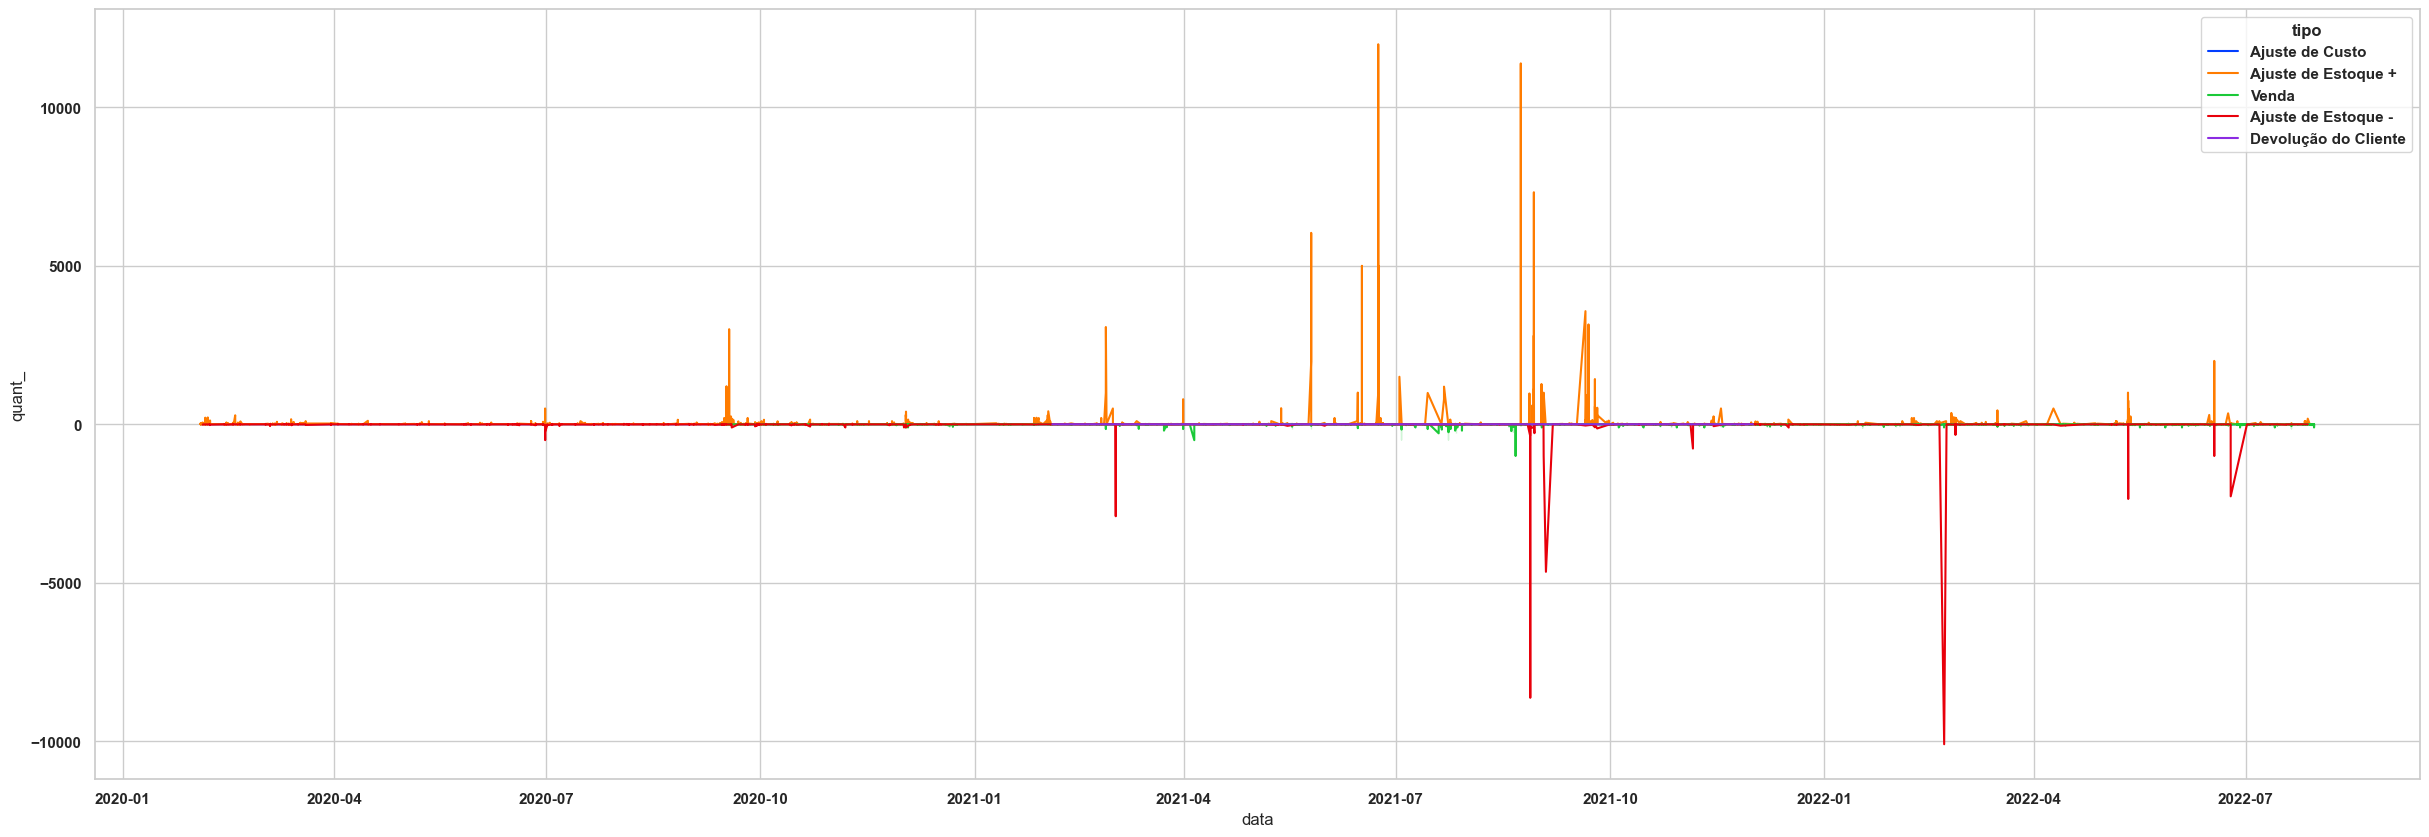

In [18]:
#Analisando Dados de estocagem com vendas
sns.lineplot(x= 'data',y = 'quant_' ,data = modelo_transac_prod, hue='tipo', palette='bright')

### FALAR COM A ANA 'Estoque -' == 'Venda'?


### Dados de Venda

In [16]:
modelo_transac_prod_vendas = modelo_transac_prod[modelo_transac_prod['tipo'] == 'Venda']
modelo_transac_prod_vendas['quant_'] = modelo_transac_prod_vendas['quant_']*-1
modelo_transac_prod_vendas


,tipo,numero,data,hora,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,gerado_clf_auto,total,codigo,categoria
4,Venda,36767,2022-06-09 10:42:36.640,2022-06-09 10:42:36.640,PAPEL DECOUPAGE-AFQ-032,1.0,3.0,3.0,0.00,0,S,3.00,37013810,papelaria
5,Venda,36547,2022-06-03 09:31:31.703,2022-06-03 09:31:31.703,BASTIDOR MDF - 18CM,1.0,8.5,8.5,0.00,0,S,8.50,32968828,mdf
6,Venda,36426,2022-05-30 16:24:04.069,2022-05-30 16:24:04.069,FRALDA BOCA NICOLI - ROSA,2.0,4.8,9.6,0.00,0,S,9.60,30058838,enxoval
7,Venda,36392,2022-05-28 10:42:32.680,2022-05-28 10:42:32.680,"AGULHA CROCHÊ ESMALTADA - 2,5M",1.0,7.0,7.0,0.22,0,S,6.78,18828463,armarinho
8,Venda,36367,2022-05-27 14:08:31.247,2022-05-27 14:08:31.247,"AGULHA CROCHÊ MILWARD 5,5 mm",1.0,7.0,7.0,0.69,0,S,6.31,98947493,armarinho
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36476,Venda,11638,2020-09-13 16:46:32.133,2020-09-13 16:46:32.133,Linha Rayza - Lilás,2.0,8.5,17.0,0.00,0,N,17.00,98006,linha
36477,Venda,11637,2020-09-13 16:45:49.784,2020-09-13 16:45:49.784,COSTURA DRIMA - 6104,1.0,2.0,2.0,0.00,0,N,2.00,7099730,linha
36478,Venda,11637,2020-09-13 16:45:49.784,2020-09-13 16:45:49.784,COSTURA DRIMA - 5878,1.0,2.0,2.0,0.00,0,N,2.00,N126100-005876,linha
36479,Venda,11637,2020-09-13 16:45:49.784,2020-09-13 16:45:49.784,COSTURA DRIMA - PT,1.0,2.0,2.0,0.00,0,N,2.00,098930,linha


In [17]:
modelo_transac_prod_vendas = modelo_transac_prod_vendas.groupby(['numero','categoria','data']).agg({'quant_': 'sum','total':'sum'}).reset_index()
modelo_transac_prod_vendas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12172 entries, 0 to 12171
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   numero     12172 non-null  int64         
 1   categoria  12172 non-null  object        
 2   data       12172 non-null  datetime64[ns]
 3   quant_     12172 non-null  float64       
 4   total      12172 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 475.6+ KB


In [18]:
#modelo_transac_prod_vendas normalize quant_ field
modelo_transac_prod_vendas['qtd_norm'] = (modelo_transac_prod_vendas['quant_'] - modelo_transac_prod_vendas['quant_'].min())/ (modelo_transac_prod_vendas['quant_'].max() - modelo_transac_prod_vendas['quant_'].min())
modelo_transac_prod_vendas['data_dia'] = modelo_transac_prod_vendas['data'].dt.date
modelo_transac_prod_vendas['ano'] = modelo_transac_prod_vendas['data'].dt.year
modelo_transac_prod_vendas['mes'] = modelo_transac_prod_vendas['data'].dt.month
modelo_transac_prod_vendas['mes_ano'] = modelo_transac_prod_vendas['data_dia'].astype(str).str[0:7]
modelo_transac_prod_vendas

,numero,categoria,data,quant_,total,qtd_norm,data_dia,ano,mes,mes_ano
0,11637,linha,2020-09-13 16:45:49.784,4.00,8.00,0.003988,2020-09-13,2020,9,2020-09
1,11638,linha,2020-09-13 16:46:32.133,2.00,17.00,0.001988,2020-09-13,2020,9,2020-09
2,11639,linha,2020-09-13 16:47:04.101,1.00,8.50,0.000988,2020-09-13,2020,9,2020-09
3,11640,linha,2020-09-13 16:47:59.107,4.00,34.00,0.003988,2020-09-13,2020,9,2020-09
4,11641,linha,2020-09-13 16:50:17.444,1.00,12.90,0.000988,2020-09-13,2020,9,2020-09
...,...,...,...,...,...,...,...,...,...,...
12167,38248,papelaria,2022-07-29 17:29:13.607,1.00,16.80,0.000988,2022-07-29,2022,7,2022-07
12168,38251,armarinho,2022-07-30 09:36:37.140,1.00,5.80,0.000988,2022-07-30,2022,7,2022-07
12169,38251,linha,2022-07-30 09:36:37.140,2.00,6.00,0.001988,2022-07-30,2022,7,2022-07
12170,38252,armarinho,2022-07-30 09:45:20.596,100.00,28.00,0.099989,2022-07-30,2022,7,2022-07


In [19]:
#ajustando o campo data para o formato datetime para poder fazer o agrupamento
modelo_transac_prod_vendas_diario = modelo_transac_prod_vendas[['numero','categoria','data_dia','ano','mes','mes_ano','quant_','qtd_norm','total']].sort_values(by=['data_dia'], ascending=True)

Remoção das categorias Roupas, Serviços e Decoração por não conterem dados relevantes ao estudo.

In [20]:
modelo_transac_prod_vendas_diario_ajust = modelo_transac_prod_vendas_diario.query("categoria != 'roupas' & categoria != 'decoracao' & categoria != 'servicos' & categoria != 'outros' ")
modelo_transac_prod_vendas_diario_ajust

,numero,categoria,data_dia,ano,mes,mes_ano,quant_,qtd_norm,total
0,11637,linha,2020-09-13,2020,9,2020-09,4.00,0.003988,8.00
15,11654,tecido,2020-09-13,2020,9,2020-09,2.00,0.001988,12.00
14,11651,armarinho,2020-09-13,2020,9,2020-09,4.00,0.003988,0.80
12,11649,armarinho,2020-09-13,2020,9,2020-09,4.00,0.003988,6.00
11,11648,armarinho,2020-09-13,2020,9,2020-09,1.00,0.000988,10.00
...,...,...,...,...,...,...,...,...,...
12156,38237,la,2022-07-29,2022,7,2022-07,1.00,0.000988,6.80
12170,38252,armarinho,2022-07-30,2022,7,2022-07,100.00,0.099989,28.00
12168,38251,armarinho,2022-07-30,2022,7,2022-07,1.00,0.000988,5.80
12169,38251,linha,2022-07-30,2022,7,2022-07,2.00,0.001988,6.00


A título de estudo, será utilizado o princípio de Pareto no qual será feito:
* O método é um grafico de barras representando o percentual da frequencia enquanto o gráfico de linhas siginifica seu total acumulado. 
* Com isso, obtém-se a relação de pareto no qual 20% da frequência dos fatores presentes representa 80% do Impacto.



O objetivo desta parcela de análise é a busca das principais categorias que afetam positivamente a receita do local de estudo. I.e., principais categorias que são vendidas e trazem mais retorno. Com isso, reduziremos os escopo da aplicação dos modelos caso aos 3 principais causadores de receita presentes no na relação "80-20".
O critério de redução ainda possui a inferência dos resultados dos passos anteriores de teste ADF. Caso não sejam séries estacionárias, não serão aplicados os modelos matemáticos de ARIMA e SARIMA. Entretanto, o modelo de XGBoost continuará a ser usado neste caso.

In [21]:
#pareto chart by categoria considering total value and total quantity

df = modelo_transac_prod_vendas_diario_ajust.groupby(['categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
df['total_perc'] = df['total']/df['total'].sum()
df['total_perc_acum'] = df['total_perc'].cumsum()
df


,categoria,quant_,total,total_perc,total_perc_acum
0,armarinho,24466.86484,34446.63,0.128905,0.128905
1,artesanato,217.00000,5165.37,0.019330,0.148235
2,aviamento,135.20000,191.80,0.000718,0.148953
3,enxoval,933.00000,18158.38,0.067952,0.216904
4,la,4226.00000,52126.08,0.195065,0.411969
5,linha,9187.00000,115913.23,0.433767,0.845736
6,mdf,708.00000,7485.85,0.028013,0.873750
7,papelaria,6517.16000,28033.59,0.104906,0.978656
8,tecido,3666.85000,5703.64,0.021344,1.000000


In [22]:
df.sort_values(by=['total'], inplace=True, ascending=False)
df

,categoria,quant_,total,total_perc,total_perc_acum
5,linha,9187.00000,115913.23,0.433767,0.845736
4,la,4226.00000,52126.08,0.195065,0.411969
0,armarinho,24466.86484,34446.63,0.128905,0.128905
7,papelaria,6517.16000,28033.59,0.104906,0.978656
3,enxoval,933.00000,18158.38,0.067952,0.216904
6,mdf,708.00000,7485.85,0.028013,0.873750
8,tecido,3666.85000,5703.64,0.021344,1.000000
1,artesanato,217.00000,5165.37,0.019330,0.148235
2,aviamento,135.20000,191.80,0.000718,0.148953


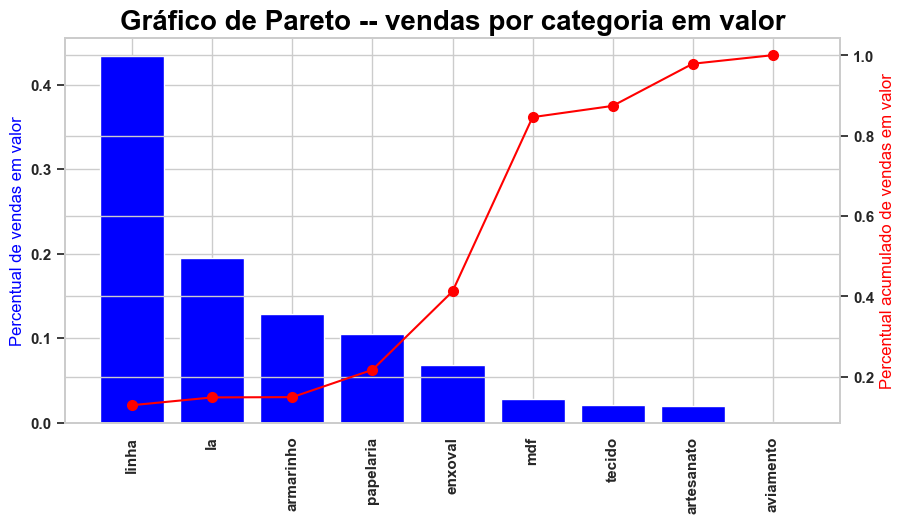

In [23]:

#plot df
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.bar(df['categoria'], df['total_perc'].sort_values(ascending = False), color='blue')
ax2.plot(df['categoria'], df['total_perc_acum'].sort_values(ascending = True), color='red', marker='o', ms=7)
ax1.set_xticklabels(df['categoria'], rotation=90)
ax1.set_ylabel('Percentual de vendas em valor', color='blue')
ax2.set_ylabel('Percentual acumulado de vendas em valor', color='red')
plt.title('Gráfico de Pareto -- vendas por categoria em valor', fontsize=20, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')
plt.show()


Tendo que as categorias que mais inferem positivamente nas vendas sendo respectivamente na seguinte ordem:
* Linha
* Lã
* Armarinho
* Papelaria

Seguindo o critério definido no estudo, e considerando os testes de ADF, a categorias escolhidas para o estudo foram:
* Linha
* Lã
* Armarinho 

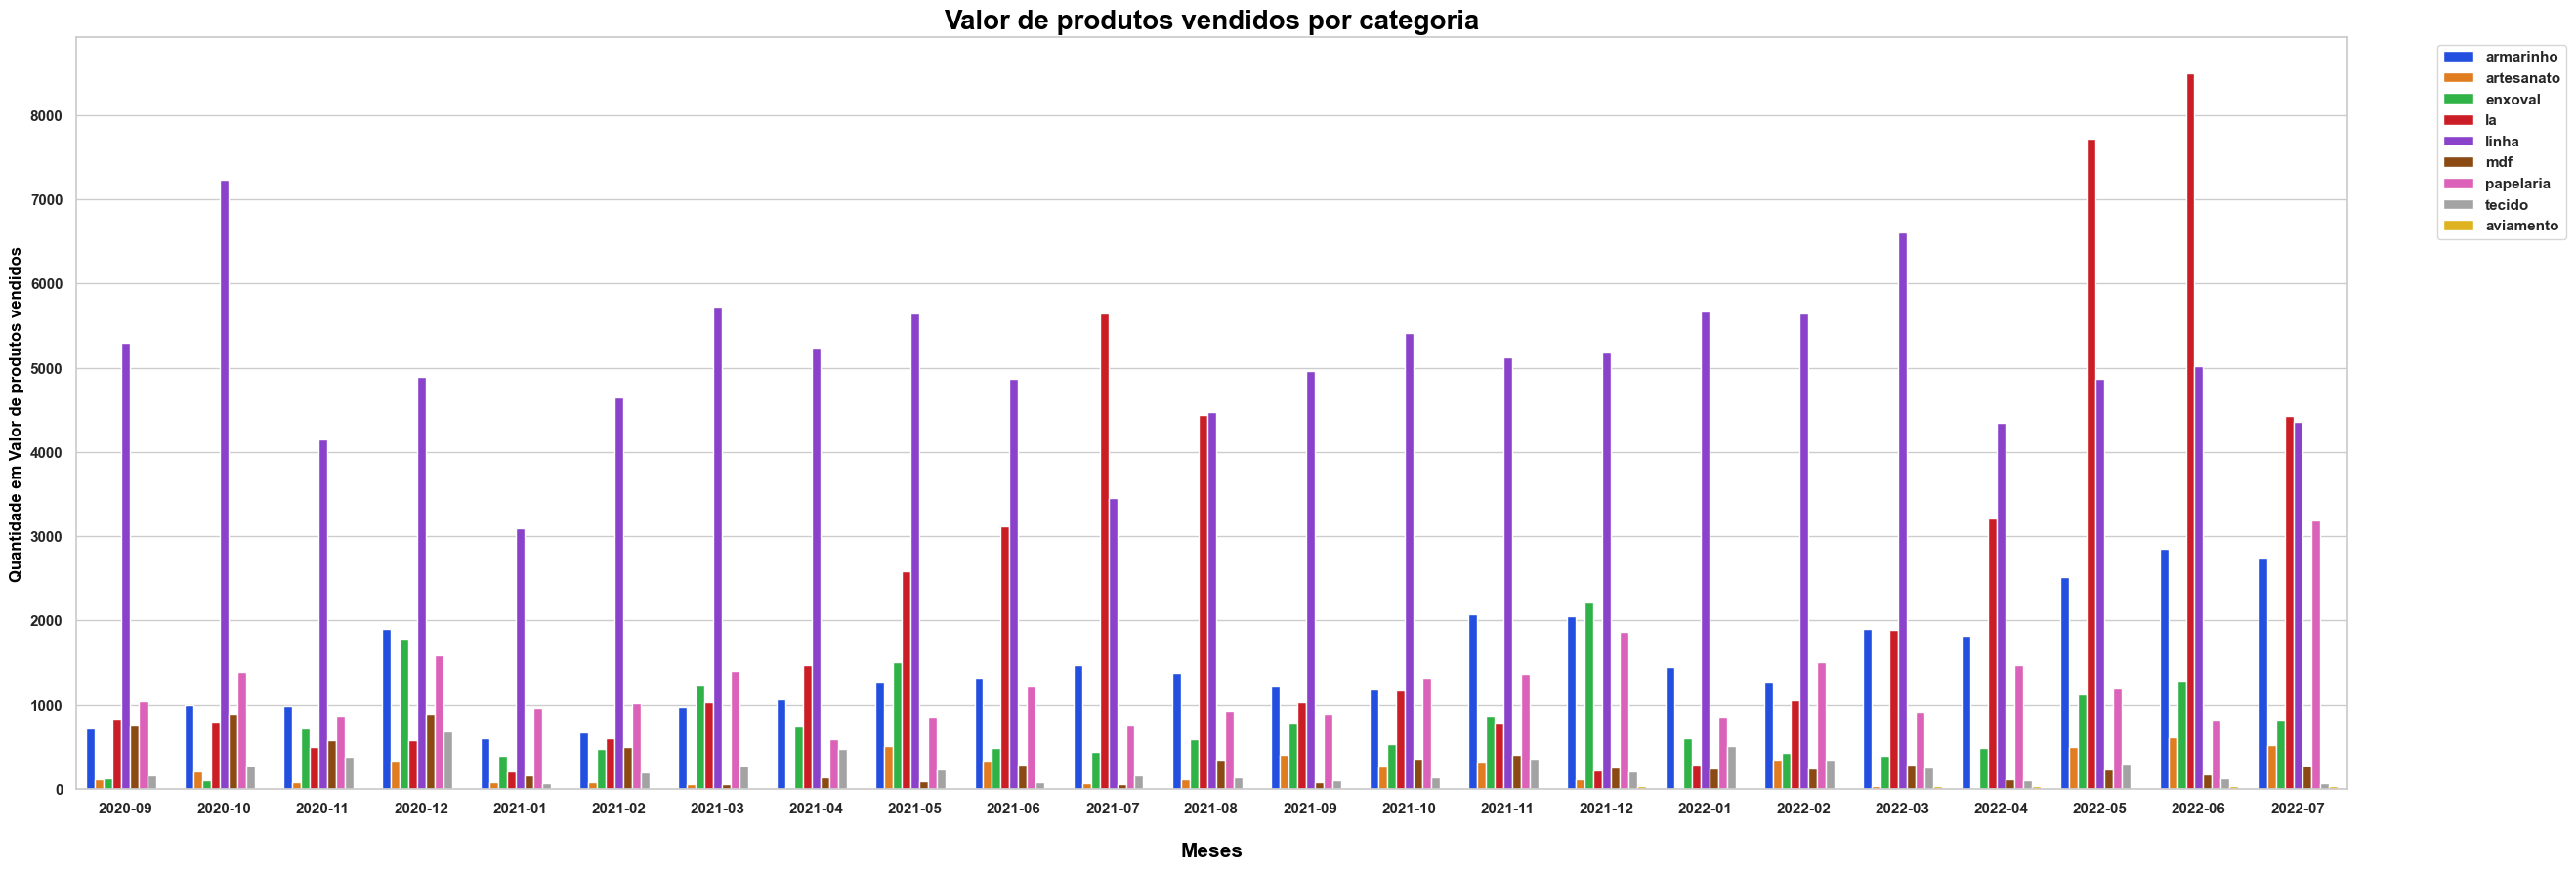

In [24]:
df = modelo_transac_prod_vendas_diario_ajust.groupby(['mes_ano','mes','categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
sns.barplot(x='mes_ano', y='total', data=df, hue='categoria', palette='bright')
plt.title('Valor de produtos vendidos por categoria', fontsize=20, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')
plt.xlabel('Meses', fontsize=15, fontweight='bold', fontfamily='sans-serif', color='black', labelpad=20)
plt.figsize=(10,16)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.ylabel('Quantidade em Valor de produtos vendidos', fontsize=12, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')
plt.show()

Text(0, 0.5, 'Quantidade em unidades de produtos vendidos')

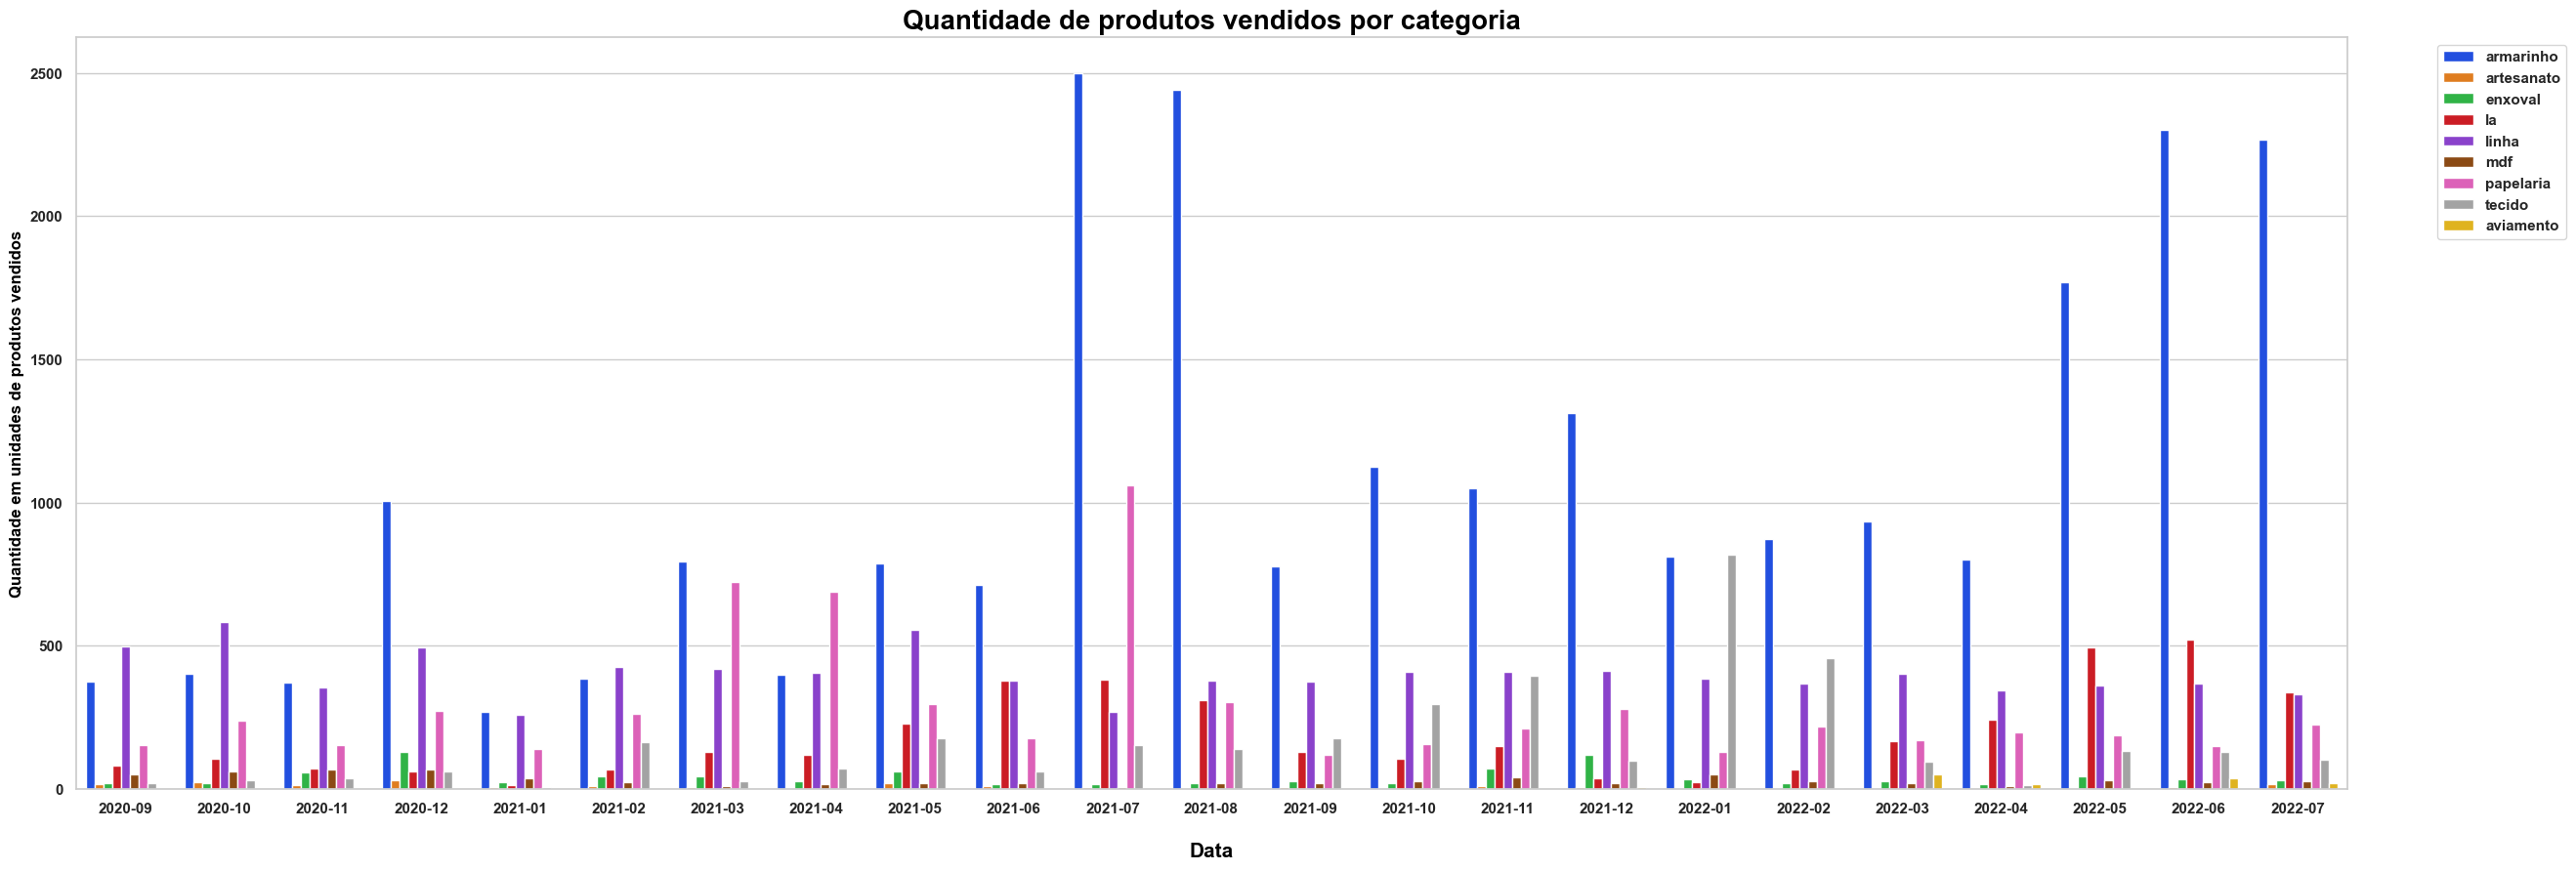

In [25]:
df = modelo_transac_prod_vendas_diario_ajust.groupby(['mes_ano','mes','categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
sns.barplot(x='mes_ano', y='quant_', data=df, hue='categoria', palette='bright')
plt.title('Quantidade de produtos vendidos por categoria', fontsize=20, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')
plt.xlabel('Data', fontsize=15, fontweight='bold', fontfamily='sans-serif', color='black', labelpad=20)
plt.figsize=(10,12)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.ylabel('Quantidade em unidades de produtos vendidos', fontsize=12, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')

In [26]:
dados_modelo = modelo_transac_prod_vendas_diario_ajust.query("categoria == 'linha' | categoria == 'la' | categoria == 'armarinho'")
dados_modelo

,numero,categoria,data_dia,ano,mes,mes_ano,quant_,qtd_norm,total
0,11637,linha,2020-09-13,2020,9,2020-09,4.0,0.003988,8.0
14,11651,armarinho,2020-09-13,2020,9,2020-09,4.0,0.003988,0.8
12,11649,armarinho,2020-09-13,2020,9,2020-09,4.0,0.003988,6.0
11,11648,armarinho,2020-09-13,2020,9,2020-09,1.0,0.000988,10.0
9,11646,linha,2020-09-13,2020,9,2020-09,2.0,0.001988,31.0
...,...,...,...,...,...,...,...,...,...
12145,38225,linha,2022-07-29,2022,7,2022-07,1.0,0.000988,3.0
12156,38237,la,2022-07-29,2022,7,2022-07,1.0,0.000988,6.8
12170,38252,armarinho,2022-07-30,2022,7,2022-07,100.0,0.099989,28.0
12168,38251,armarinho,2022-07-30,2022,7,2022-07,1.0,0.000988,5.8


In [59]:
dados_modelo.to_excel('features/dados_modelo.xlsx', index=False, encoding='utf-8', engine='openpyxl', sheet_name='dados_modelo')